In [2]:
# 03 - Exploratory Graph Analysis
## Visualizing the Bipartite User-Book Graph

import torch
from torch_geometric.data import Data
from torch_geometric.utils import degree, to_networkx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pickle
import psutil
import gc



In [3]:
## 1. Load Graph and Mappings

from torch_geometric.data.data import DataTensorAttr, DataEdgeAttr
from torch_geometric.data.storage import GlobalStorage
import torch.serialization

torch.serialization.add_safe_globals([DataTensorAttr, DataEdgeAttr, GlobalStorage])

data = torch.load('data/processed/graph_data.pt')

with open('data/processed/user_mapping.pkl', 'rb') as f:
    user_map = pickle.load(f)
with open('data/processed/book_mapping.pkl', 'rb') as f:
    book_map = pickle.load(f)

num_users = data.num_users
num_books = data.num_books

print(data)


Data(x=[5582, 64], edge_index=[2, 95220], num_nodes=5582, num_users=3404, num_books=2178)


Avg ratings per user: 13.99
Avg ratings per book: 21.86


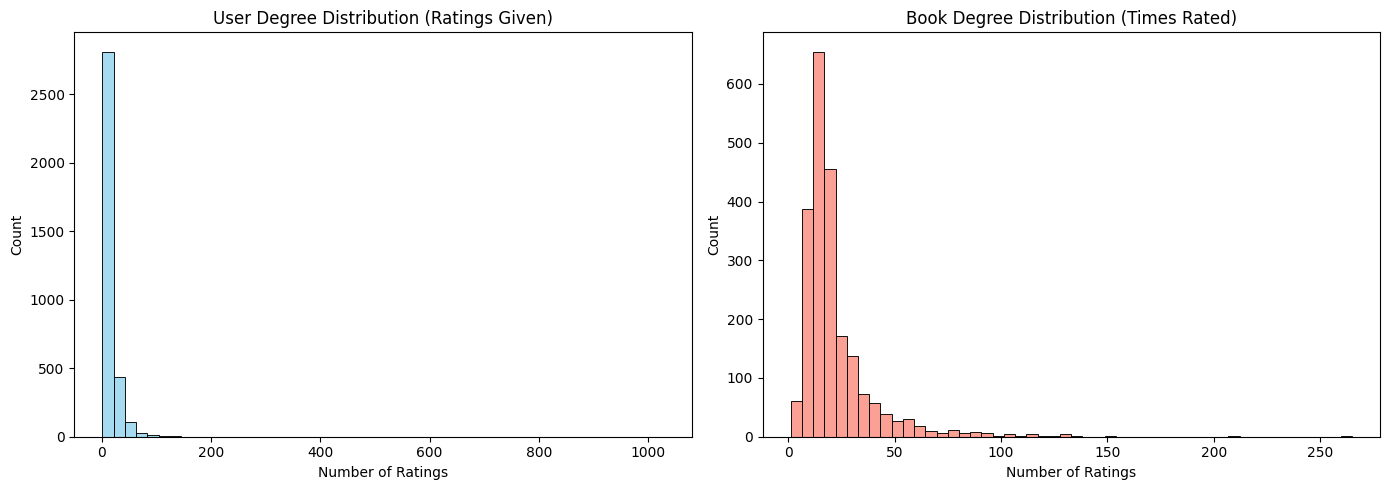

In [4]:
## 2. Degree Distributions

# Compute degrees
degrees = degree(data.edge_index[0], num_nodes=data.num_nodes).numpy()

user_degrees = degrees[:num_users]
book_degrees = degrees[num_users:]

print(f"Avg ratings per user: {user_degrees.mean():.2f}")
print(f"Avg ratings per book: {book_degrees.mean():.2f}")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(user_degrees, bins=50, ax=axes[0], color='skyblue')
axes[0].set_title('User Degree Distribution (Ratings Given)')
axes[0].set_xlabel('Number of Ratings')
axes[0].set_ylabel('Count')

sns.histplot(book_degrees, bins=50, ax=axes[1], color='salmon')
axes[1].set_title('Book Degree Distribution (Times Rated)')
axes[1].set_xlabel('Number of Ratings')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [5]:
## 3. Top Active Users and Popular Books

# Top 10 users
user_deg = sorted(enumerate(user_degrees), key=lambda x: x[1], reverse=True)[:10]
top_user_nodes = [i for i, _ in user_deg]
top_user_ids = [user_map['node_to_user'][n] for n in top_user_nodes]

# Top 10 books
book_deg = sorted(enumerate(book_degrees), key=lambda x: x[1], reverse=True)[:10]
top_book_nodes = [i for i, _ in book_deg]
top_book_isbns = [book_map['node_to_book'][n] for n in top_book_nodes]

print("Top 10 Most Active Users (User-ID):")
print(top_user_ids)
print("\nTop 10 Most Popular Books (ISBN):")
print(top_book_isbns)

Top 10 Most Active Users (User-ID):
[np.int64(11676), np.int64(16795), np.int64(95359), np.int64(104636), np.int64(153662), np.int64(60244), np.int64(158295), np.int64(114368), np.int64(35859), np.int64(258534)]

Top 10 Most Popular Books (ISBN):
['0316666343', '0385504209', '059035342X', '0312195516', '043935806X', '0679781587', '0345337662', '0142001740', '0060928336', '0971880107']


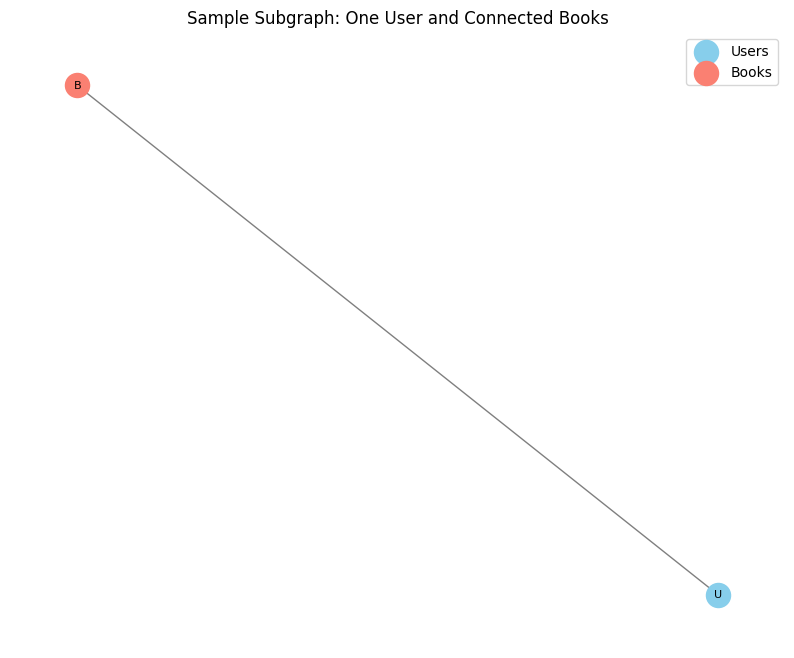

In [6]:
## 4. Small Subgraph Visualization (Sample)

# Sample a small connected component for visualization
G = to_networkx(data, to_undirected=True)

# Take a small subset (e.g., one user and their neighbors)
sample_user_node = 0  # first user
neighbors = list(G.neighbors(sample_user_node))
sub_nodes = [sample_user_node] + neighbors[:20]  # limit for clarity
subgraph = G.subgraph(sub_nodes)

# Plot
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(subgraph, k=0.5, iterations=50)

user_nodes_sub = [n for n in sub_nodes if n < num_users]
book_nodes_sub = [n for n in sub_nodes if n >= num_users]

nx.draw_networkx_nodes(subgraph, pos, nodelist=user_nodes_sub, node_color='skyblue', label='Users', node_size=300)
nx.draw_networkx_nodes(subgraph, pos, nodelist=book_nodes_sub, node_color='salmon', label='Books', node_size=300)
nx.draw_networkx_edges(subgraph, pos, alpha=0.5)
nx.draw_networkx_labels(subgraph, pos, labels={n: 'U' if n < num_users else 'B' for n in sub_nodes}, font_size=8)

plt.title('Sample Subgraph: One User and Connected Books')
plt.legend()
plt.axis('off')
plt.show()

In [7]:
## 5. Summary

print("Graph Analysis Complete!")
print(f"- Well-connected bipartite graph with {num_users} users and {num_books} books")
print(f"- Average user activity: {user_degrees.mean():.1f} ratings")
print(f"- Average book popularity: {book_degrees.mean():.1f} ratings")
print(f"- This structure is excellent for LightGCN: enough density for message passing")

gc.collect()


Graph Analysis Complete!
- Well-connected bipartite graph with 3404 users and 2178 books
- Average user activity: 14.0 ratings
- Average book popularity: 21.9 ratings
- This structure is excellent for LightGCN: enough density for message passing


4506